# Flora Prepper Model Evaluation
## Initialize the environment

In [1]:
from src.data.make_fna import *
from src.data.make_bc import *
from src.data.make_budds import *
from src.models.train_model import *
from src.visualization.visualize import *
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

## Import the data

In [2]:
fna = make_fna_data_frame(fna_filepath="../data/external/fna_keys.csv", frac_to_sample=0.1, balance_categories=True,
                          categories_to_keep=["key", "morphology", "taxon_identification", "distribution"])
bc = make_bc_data_frame(bc_filepath="../data/external/eflora-bc-partial.csv",
                        frac_to_sample=0.15, balance_categories=True)
budds = make_budds_data_frame(budds_file_path="../data/external/buddsfloraofcana00otta_djvu.xml", frac_to_sample=1,
                              balance_categories=True)
flora_data_frame = pd.concat([fna, bc, budds], keys=['fna', 'bc', 'budds'], names=['Dataset name', 'Row ID'])

/Users/jocelynpender/miniconda3/envs/flora-prepper/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


## Visualize the data
### Visualize counts of training datasets

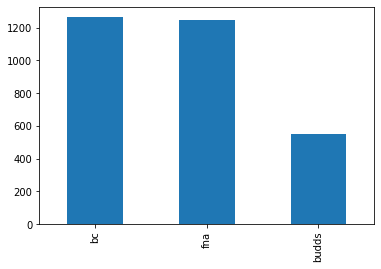

In [3]:
flora_data_frame = flora_data_frame.reset_index()
flora_data_frame['Dataset name'].value_counts().plot.bar()
plt.show()

### View a word cloud for all text data 
Text is processed using the same custom (bare-bones) tokenizer and stopwords used to train the model. 


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jocelynpender/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


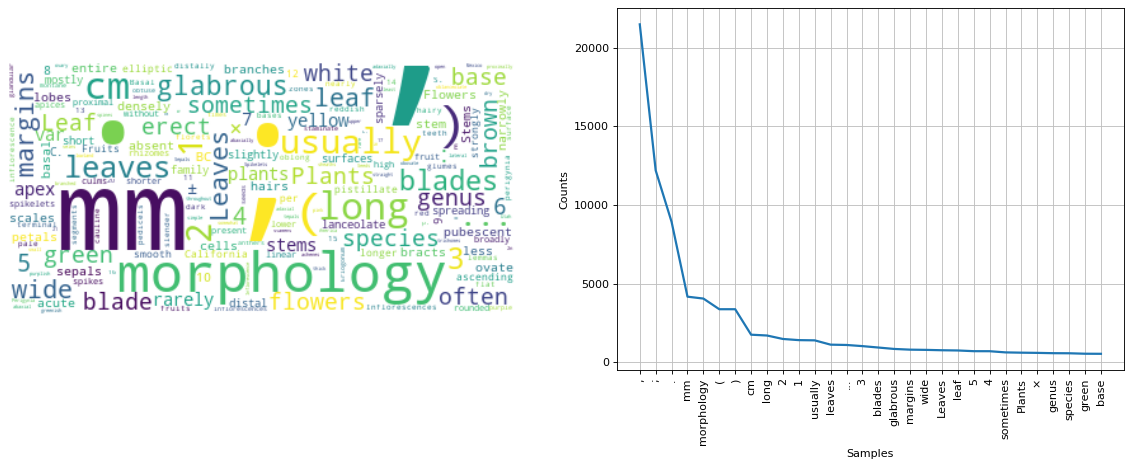

[(',', 21489), (';', 12197), ('.', 8924), ('mm', 4165), ('morphology', 4045), ('(', 3367), (')', 3367), ('cm', 1747), ('long', 1695), ('2', 1475), ('1', 1401), ('usually', 1387), ('leaves', 1113), ('...', 1093), ('3', 1020), ('blades', 930), ('glabrous', 840), ('margins', 795), ('wide', 781), ('Leaves', 757), ('leaf', 743), ('5', 698), ('4', 696), ('sometimes', 621), ('Plants', 603), ('×', 590), ('genus', 570), ('species', 565), ('green', 536), ('base', 531)]


In [4]:
tokenized_stop_words = prepare_stop_words(custom_stop_words=["unknown", "accepted", "synonym",
                                                             "basionym", "source",
                                                             "note", "notes"])  # Find a way to keep numbers and elipses!
text = " ".join(text_string for text_string in flora_data_frame.text)
visualize_words(text, tokenized_stop_words)

### Generate word clouds by classification.
Are there any noticeable differences between the words used most frequently between the classifications?

In [5]:
taxon_identification = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "taxon_identification"].text)
morphology = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "morphology"].text)
key = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "key"].text)
habitat = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "habitat"].text)

Taxon identification

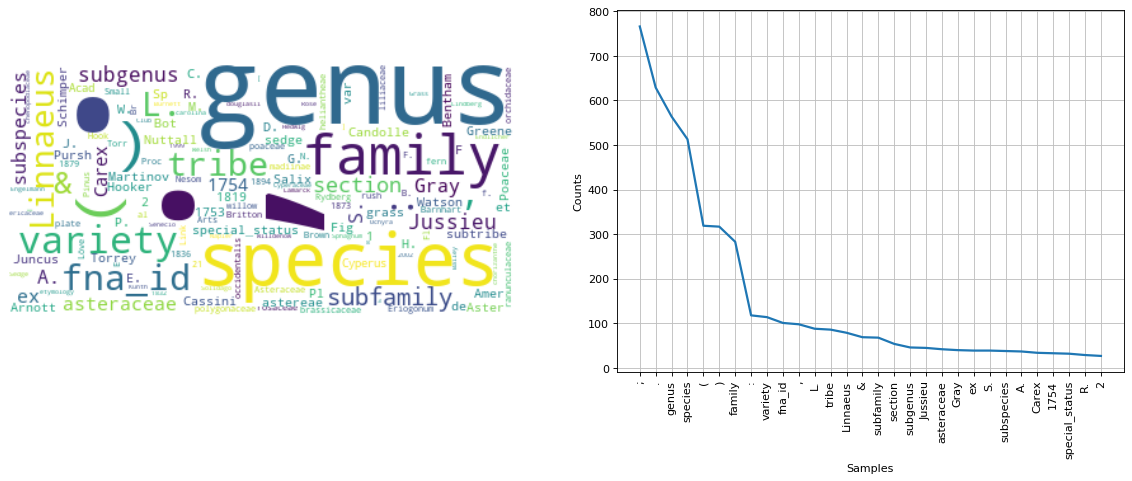

[(';', 766), ('.', 629), ('genus', 564), ('species', 513), ('(', 319), (')', 317), ('family', 283), (':', 118), ('variety', 114), ('fna_id', 101), (',', 98), ('L.', 88), ('tribe', 86), ('Linnaeus', 79), ('&', 69), ('subfamily', 68), ('section', 54), ('subgenus', 46), ('Jussieu', 45), ('asteraceae', 42), ('Gray', 40), ('ex', 39), ('S.', 39), ('subspecies', 38), ('A.', 37), ('Carex', 34), ('1754', 33), ('special_status', 32), ('R.', 29), ('2', 27)]


In [6]:
visualize_words(taxon_identification, tokenized_stop_words)

Morphology

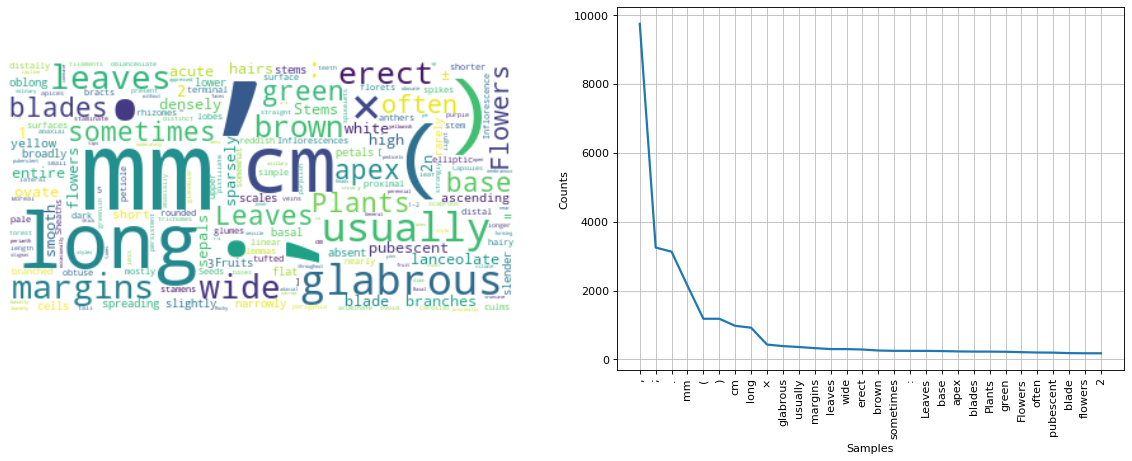

[(',', 9742), (';', 3248), ('.', 3128), ('mm', 2140), ('(', 1181), (')', 1181), ('cm', 976), ('long', 922), ('×', 432), ('glabrous', 387), ('usually', 361), ('margins', 328), ('leaves', 301), ('wide', 300), ('erect', 288), ('brown', 259), ('sometimes', 250), (':', 249), ('Leaves', 248), ('base', 243), ('apex', 233), ('blades', 228), ('Plants', 227), ('green', 223), ('Flowers', 211), ('often', 201), ('pubescent', 198), ('blade', 183), ('flowers', 179), ('2', 178)]


In [7]:
visualize_words(morphology, tokenized_stop_words)

Keys

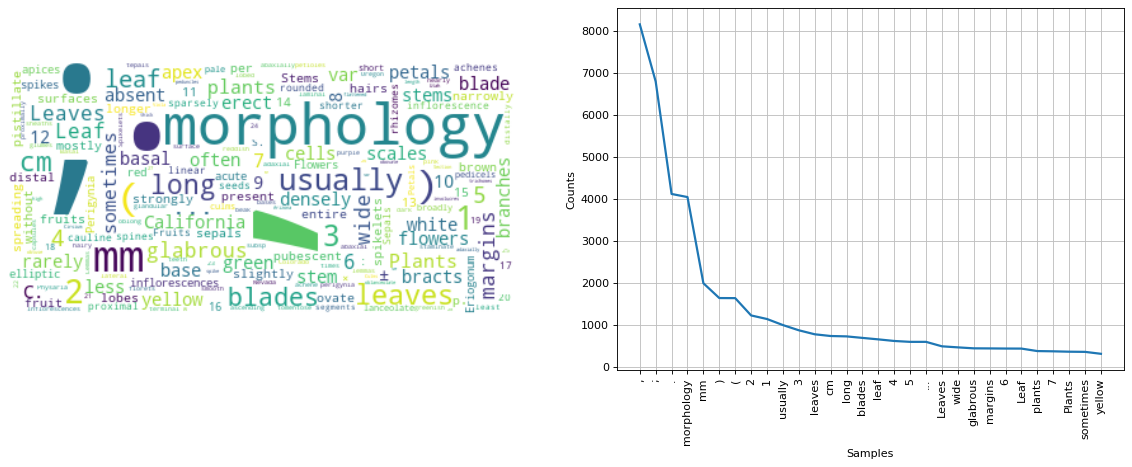

[(',', 8150), (';', 6791), ('.', 4119), ('morphology', 4045), ('mm', 1997), (')', 1645), ('(', 1643), ('2', 1232), ('1', 1147), ('usually', 1003), ('3', 879), ('leaves', 784), ('cm', 743), ('long', 734), ('blades', 698), ('leaf', 663), ('4', 625), ('5', 604), ('...', 604), ('Leaves', 498), ('wide', 473), ('glabrous', 450), ('margins', 448), ('6', 445), ('Leaf', 444), ('plants', 385), ('7', 379), ('Plants', 370), ('sometimes', 366), ('yellow', 320)]


In [8]:
visualize_words(key, tokenized_stop_words)

Habitat

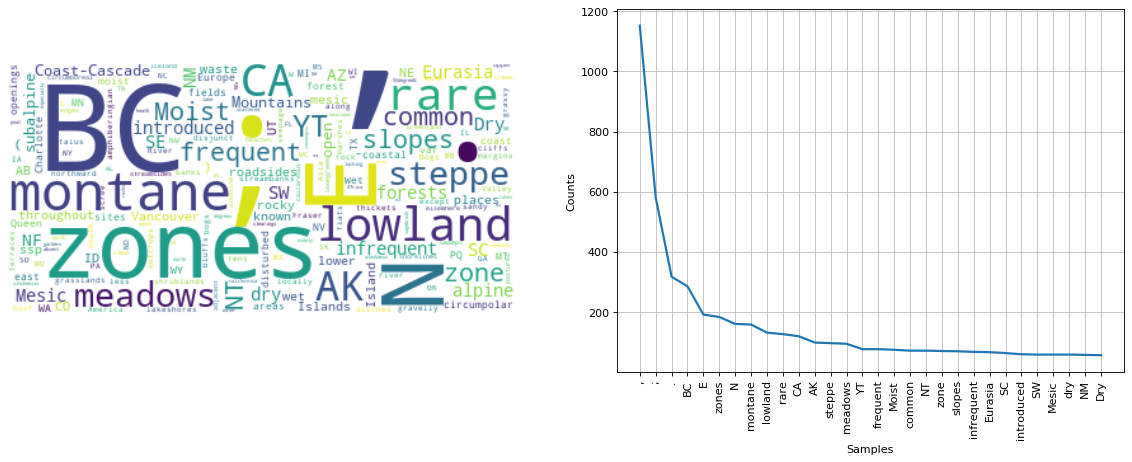

[(',', 1152), (';', 581), ('.', 317), ('BC', 285), ('E', 191), ('zones', 183), ('N', 160), ('montane', 158), ('lowland', 131), ('rare', 126), ('CA', 119), ('AK', 98), ('steppe', 96), ('meadows', 94), ('YT', 76), ('frequent', 76), ('Moist', 74), ('common', 71), ('NT', 71), ('zone', 70), ('slopes', 69), ('infrequent', 67), ('Eurasia', 66), ('SC', 63), ('introduced', 59), ('SW', 58), ('Mesic', 58), ('dry', 58), ('NM', 57), ('Dry', 56)]


In [9]:
visualize_words(habitat, tokenized_stop_words)


### Word clouds by flora source
Are there differences between training sets in the most commonly used words?

In [10]:
bc_text = " ".join(text_string for text_string in bc.text if text_string not in tokenized_stop_words)
budds_text = " ".join(text_string for text_string in budds.text if text_string not in tokenized_stop_words)
fna_text = " ".join(text_string for text_string in fna.text if text_string not in tokenized_stop_words)


BC

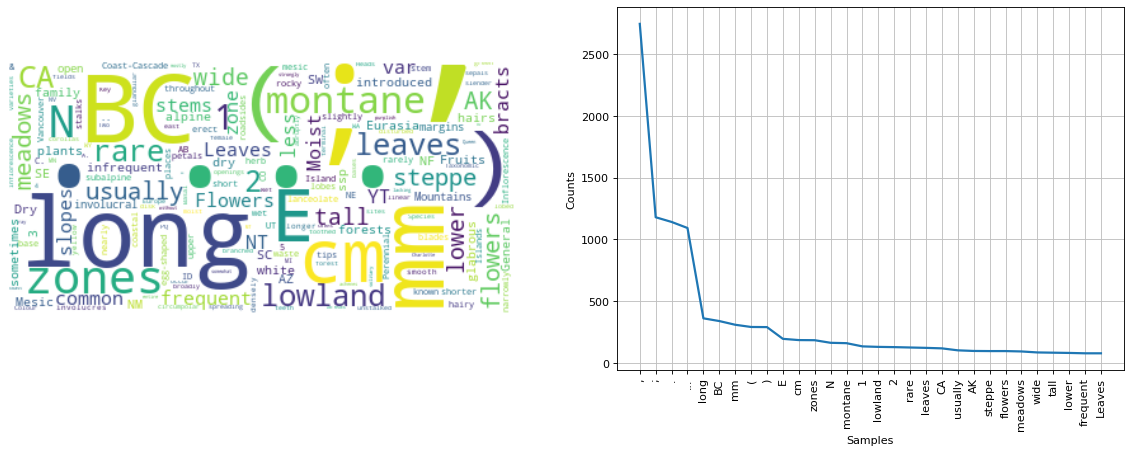

[(',', 2745), (';', 1180), ('.', 1142), ('...', 1093), ('long', 362), ('BC', 340), ('mm', 310), ('(', 292), (')', 291), ('E', 196), ('cm', 186), ('zones', 185), ('N', 164), ('montane', 161), ('1', 135), ('lowland', 131), ('2', 129), ('rare', 126), ('leaves', 123), ('CA', 119), ('usually', 103), ('AK', 98), ('steppe', 97), ('flowers', 97), ('meadows', 94), ('wide', 86), ('tall', 84), ('lower', 82), ('frequent', 79), ('Leaves', 79)]


In [11]:
visualize_words(bc_text, tokenized_stop_words)

FNA

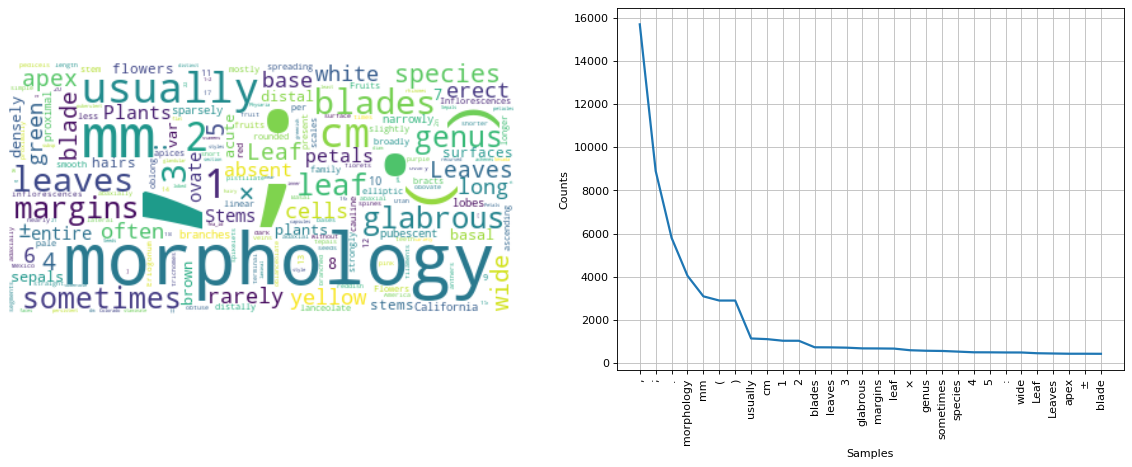

[(',', 15705), (';', 8904), ('.', 5805), ('morphology', 4044), ('mm', 3090), ('(', 2895), (')', 2895), ('usually', 1136), ('cm', 1106), ('1', 1031), ('2', 1030), ('blades', 727), ('leaves', 723), ('3', 710), ('glabrous', 676), ('margins', 673), ('leaf', 666), ('×', 590), ('genus', 567), ('sometimes', 557), ('species', 527), ('4', 495), ('5', 493), (':', 487), ('wide', 486), ('Leaf', 451), ('Leaves', 439), ('apex', 428), ('±', 428), ('blade', 425)]


In [12]:
visualize_words(fna_text, tokenized_stop_words)

Budds

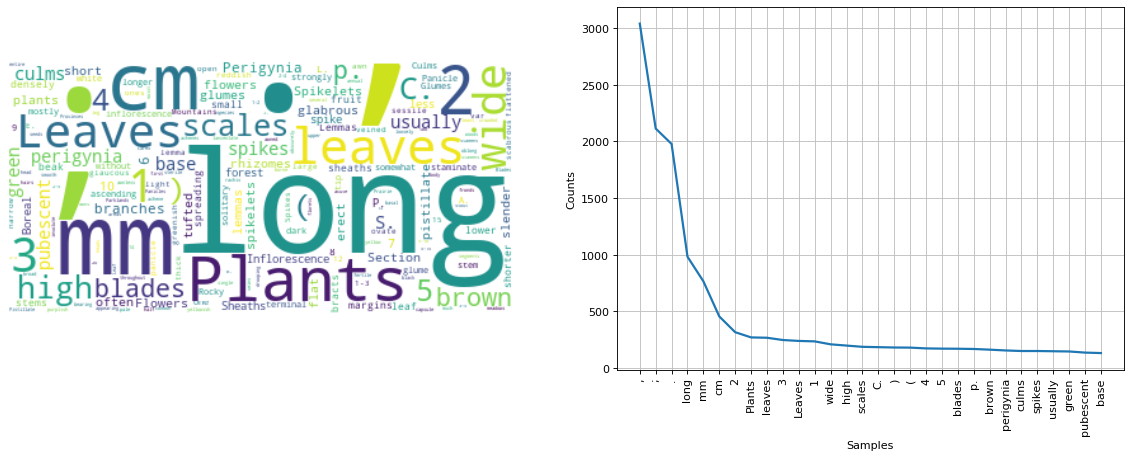

[(',', 3039), (';', 2113), ('.', 1977), ('long', 982), ('mm', 765), ('cm', 455), ('2', 316), ('Plants', 270), ('leaves', 267), ('3', 247), ('Leaves', 239), ('1', 235), ('wide', 209), ('high', 198), ('scales', 187), ('C.', 184), (')', 181), ('(', 180), ('4', 173), ('5', 171), ('blades', 170), ('p.', 168), ('brown', 162), ('perigynia', 155), ('culms', 150), ('spikes', 150), ('usually', 148), ('green', 146), ('pubescent', 136), ('base', 132)]


In [13]:
visualize_words(budds_text, tokenized_stop_words)


### What happens to the key and morphology classifications if we implement stricter word tokenization?

Key

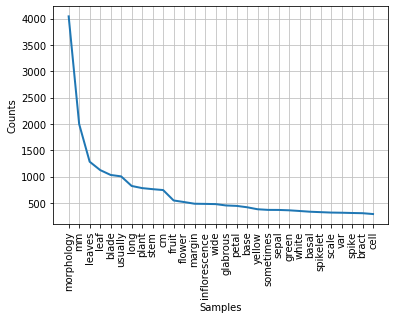

In [14]:
word_cloud_key = WordCloud(stopwords=tokenized_stop_words, 
                      background_color="white", collocations=False).process_text(key)
fdist_key = FreqDist(word_cloud_key)
fdist_key.plot(30,cumulative=False)
plt.show()

Morphology

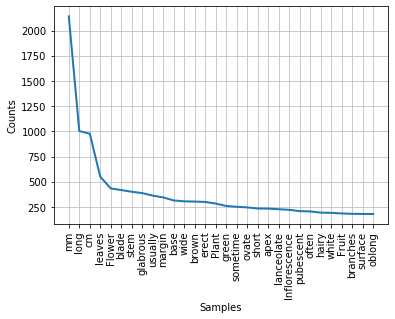

In [15]:
word_cloud_morphology = WordCloud(stopwords=tokenized_stop_words, 
                      background_color="white", collocations=False).process_text(morphology)
fdist_morphology = FreqDist(word_cloud_morphology)
fdist_morphology.plot(30,cumulative=False)
plt.show()

### Visualize distinctive words using tf-idf


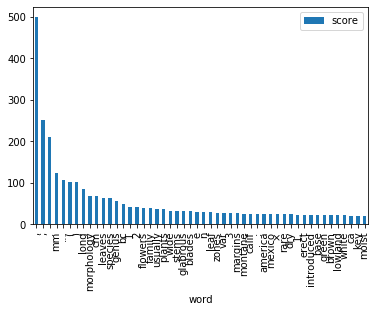

In [16]:
custom_vec = TfidfVectorizer(lowercase=True, tokenizer=flora_tokenizer, stop_words=tokenized_stop_words, ngram_range=(1, 1))
text_counts = custom_vec.fit_transform(flora_data_frame['text'])  # Build TF-IDF Matrix

scores = zip(custom_vec.get_feature_names(), np.asarray(text_counts.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
#for item in sorted_scores:
 #   print("{0:10} Score: {1}".format(item[0], item[1]))
    
sorted_scores_df = pd.DataFrame(sorted_scores, columns=['word', 'score']).iloc[:50]
sorted_scores_df.plot.bar(x='word', y='score')
plt.show()

## Run a DTM based model and a TFIDF based model and review accuracy

In [17]:
# ==== DTM =====
dtm_text_counts = build_dtm_text_counts(flora_tokenizer, tokenized_stop_words, flora_data_frame)
predictions = run_model(dtm_text_counts, flora_data_frame)

# ==== TFIDF =====
tfidf_text_counts = build_tfidf_text_counts(flora_tokenizer, tokenized_stop_words, flora_data_frame)
predictions = run_model(tfidf_text_counts, flora_data_frame)


MultinomialNB Accuracy: 0.900871459694989
MultinomialNB Accuracy: 0.8453159041394336


#### View incorrectly classified statements

## Run a model based on text length

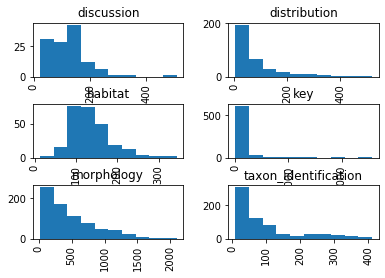

In [18]:
# Process text, remove stopwords. Remove empty cells.
length_processed_flora_data_frame = process_length_in_place(flora_data_frame, tokenized_stop_words)


plot = length_processed_flora_data_frame['length'].hist(by=length_processed_flora_data_frame['classification'])
plt.show()

It looks like discussion should be removed from the dataset. It is curiously short in length. This may be an artifact from the bc dataset.

In [ ]:

length_processed_flora_data_frame[length_processed_flora_data_frame.classification == 'discussion'].text

In [20]:
#fig,ax = plt.subplots(figsize=(5,5))
#plt.boxplot(df_train_1.phrase_len)
#plt.show()


To do plots:
classification coloured by source